In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt

In [2]:
model_name = ["OPT-1.3B", "Phi-2B", "Yi-6B", "Llama-2\n7B", "Llama-2\n13B", "Llama-3\n8B", "Geo\nMean"]
acc_list   = ["FP16", "BitMoD (lossless)", "ANT (lossy)", "OliVe (lossy)", "BitMoD (lossy)"]

cycle_fp16_d       = np.array([669255680, 1399816192, 2878668800, 3156574208, 6676111360, 3969089536])
cycle_ant_d        = np.array([440975360, 847773696,  1734868992, 1949564928, 4076584960, 2266234880])
cycle_olive_d      = np.array([403718144, 779268096,  1575157760, 1768062976, 3648512000, 2008645632])
cycle_bitmod_con_d = np.array([336236544, 693780480,  1414209536, 1649680384, 3537397760, 1901133824])
cycle_bitmod_agg_d = np.array([233070592, 515194880,  946937856,  1202921472, 2601461760, 1273233408])
cycle_discrim      = np.array([cycle_fp16_d, cycle_bitmod_con_d, cycle_ant_d, cycle_olive_d, cycle_bitmod_agg_d])
speedup_discrim    = cycle_fp16_d / cycle_discrim
speedup_discrim    = np.concatenate((speedup_discrim, np.mean(speedup_discrim, axis=-1, keepdims=True)), axis=1)

num_token_generate = 20
cycle_fp16_g       = np.array([82153718,  165841248,  362970848,  413518608,  804330080,  469624976])
cycle_ant_g        = np.array([25779238,  51998112,   119342816,  129497936,  251907680,  132370576])
cycle_olive_g      = np.array([20018374,  41655712,   96691936,   97236816,   189155680,  105031744])
cycle_bitmod_con_g = np.array([31220054,  62986912,   137681120,  156919888,  305157360,  178109840])
cycle_bitmod_agg_g = np.array([15857750,  31959712,   69662944,   79493200,   154552560,  90099088])
cycle_generate     = np.array([cycle_fp16_g, cycle_bitmod_con_g, cycle_ant_g, cycle_olive_g, cycle_bitmod_agg_g])*num_token_generate + cycle_discrim
speedup_generate   = (cycle_fp16_g*num_token_generate + cycle_fp16_d) / cycle_generate
speedup_generate   = np.concatenate((speedup_generate, np.mean(speedup_generate, axis=-1, keepdims=True)), axis=1)

speedup = np.array([speedup_discrim, speedup_generate])

In [3]:
speedup_discrim[-1] / speedup_discrim[-3]

array([1.89202488, 1.64553983, 1.83208326, 1.62069177, 1.56703628,
       1.77990529, 1.7218028 ])

## Speedup

In [4]:
linestyle   = 'solid'
alpha       = 1

xlabel_size = 10
ylabel_size = 10.5
ytick_size  = 11.5

text_size   = 9.5
legend_size = 10
title_size  = 10.5

# bar setting
width      = 0.02  # the width of each bar
edgewidth  = 0.8    # the edge width of each bar
hatchwidth = 0.5    # the edge width of each bar
spacing    = 0.144   # spacing between each model bar
distance   = 0.01   # spacing between every two bars of the same model

x          = np.arange(len(model_name))*spacing # the label locations

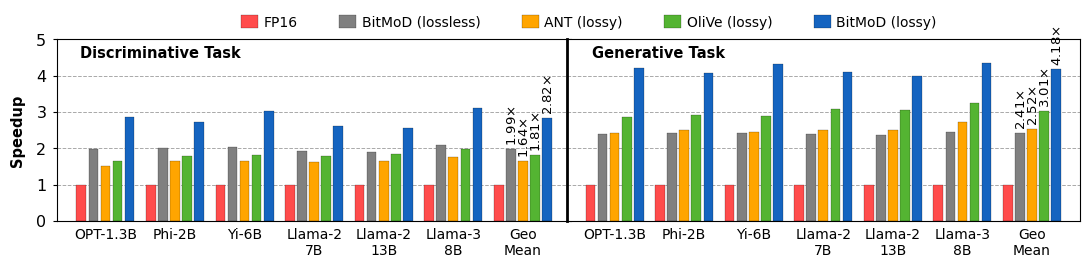

In [14]:
figwidth    = 11
figheight   = 2.6

y_title_pad = 0
y_title_loc = 0.85
rotation = 0
x_margin = 0.04


############# Draw Figures #############
f, ax = plt.subplots(1, 2)
f.set_figwidth(figwidth)
f.set_figheight(figheight)
f.tight_layout(pad=1)

f_list = [i for i in acc_list]
color_list = ['#ff4c4c', 'gray', 'orange', '#54b432', '#1564c0']
xlabels = model_name

arrow_xloc = x + width + distance/2
ymax = 5

for i in range(2):
    for j_tmp in range(-2, 3):
        j = j_tmp + 2
        f_list[j] = ax[i].bar(x + j_tmp*width + distance*j_tmp/2, speedup[i, j], 
                              width, color=color_list[j], edgecolor='black', linewidth=0.15)
    
    if i == 0:
        y_low = 0
        y_up  = ymax + 0.01
        y_lim = y_up
        ax[i].set_ylim(y_low, y_lim)
        ax[i].set_yticks(np.arange(y_low, y_up, 1))

        ax[i].set_xticks(x,)
        ax[i].set_xticklabels(xlabels, rotation=rotation)
        ax[i].tick_params(axis='y', which='major', labelsize=ytick_size, pad=5, length=3)
        ax[i].tick_params(axis='x', which='major', labelsize=xlabel_size, pad=5, length=0)
        
        ax[i].spines['right'].set_visible(False)
        ax[i].set_ylabel('Speedup', weight='bold', fontsize=ylabel_size, labelpad=8)
        
        ax[i].set_title('Discriminative Task', fontsize=title_size, weight='bold', x=0.2, y=y_title_loc)
    if i == 1:
        y_low = 0
        y_up  = ymax + 0.01
        y_lim = y_up 
        ax[i].set_ylim(y_low, y_lim)
        ax[i].set_yticks(np.arange(y_low, y_up, 1))

        ax[i].set_xticks(x,)
        ax[i].set_xticklabels(xlabels, rotation=rotation)
        ax[i].tick_params(axis='x', which='major', labelsize=xlabel_size, pad=5, length=0)
        
        ax[i].tick_params(left=False, which='both')
        ax[i].yaxis.set_tick_params(labelleft=False)
        ax[i].spines['left'].set_visible(True)
        ax[i].spines['left'].set_linewidth(2)
        
        ax[i].set_title('Generative Task', fontsize=title_size, weight='bold', x=0.18, y=y_title_loc)
    
    ax[i].margins(x=x_margin)
    ax[i].set_axisbelow(True)
    ax[i].grid(True, linestyle='dashed', axis='y', zorder=1000, color='darkgrey', linewidth=0.7)
    
    ########## Geomean Speedup Annotation ##########
    for j_tmp in range(-1, 3):
        j = j_tmp + 2
        text_x  = (len(model_name) - 1)*spacing + j_tmp*width + distance*j_tmp/2 + 0.003
        text_y  = speedup[i, j, -1] + 0.1
        txt = ax[i].annotate(text=str(round(speedup[i, j, -1], 2)) + r'$\times$', xy=(text_x, text_y), fontsize=text_size,
                             horizontalalignment='center', verticalalignment='bottom', rotation=90)
    

leg = f.legend(f_list, acc_list, loc='upper center', bbox_to_anchor=[0.54, 1.04], 
        fontsize=legend_size, ncol=5, columnspacing=3, frameon=False, edgecolor='grey', handlelength=1.2, handleheight=1, handletextpad=0.4)

plt.tight_layout(h_pad=0, w_pad=-0.3)
f.savefig('speedup.svg', transparent=True, bbox_inches = 'tight', format='svg', dpi=200, pad_inches=0.1)
